# Backtesting ML Classification-Based

## Load the model

In [1]:
import pickle

In [2]:
with open('models/model_dt_classification.pkl', 'rb') as f:
    model_dt = pickle.load(f)

In [3]:
model_dt

DecisionTreeClassifier(max_depth=15)

## Load the data

In [4]:
import pandas as pd

df = pd.read_excel('data/Microsoft_LinkedIn_Processed.xlsx', index_col=0, parse_dates=['Date'])
df

,Close,High,Low,Open,Volume,change_tomorrow,change_tomorrow_direction
Date,,,,,,,
2016-12-08,55.181118,55.696664,55.027361,55.443412,21220800,1.549151,UP
2016-12-09,56.049408,56.067498,55.289661,55.334883,27349400,0.321693,UP
2016-12-12,56.230297,56.347878,55.823293,55.913737,20198100,1.286142,UP
2016-12-13,56.962921,57.360883,56.293622,56.528781,35718900,-0.478631,DOWN
2016-12-14,56.691578,57.388013,56.555907,56.981005,30352700,-0.159796,DOWN
...,...,...,...,...,...,...,...
2025-02-28,396.989990,397.630005,386.570007,392.660004,32845700,-2.187959,DOWN
2025-03-03,388.489990,398.820007,386.160004,398.820007,23007700,0.030878,UP
2025-03-04,388.609985,392.579987,381.000000,383.399994,29342900,3.094610,UP


## Backtesting.py Library

### Create your Strategy Class

In [5]:
!pip install backtesting
from backtesting import Backtest, Strategy


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


/home/codespace/.python/current/lib/python3.12/site-packages/backtesting/_plotting.py:54: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [6]:
df_explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

In [7]:
df_explanatory.iloc[-1:, :]

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-06,394.279999,402.149994,393.299988,395.786591,8418393


In [8]:
df.change_tomorrow_direction[-1:]

Date
2025-03-06    DOWN
Name: change_tomorrow_direction, dtype: object

#### Simulate the prediction for the last observation

In [10]:
model_dt.predict(X=df_explanatory)

array(['UP', 'UP', 'UP', ..., 'UP', 'UP', 'UP'],
      shape=(2071,), dtype=object)

In [11]:
explanatory_today = df_explanatory.iloc[[-1],:]

In [12]:
forecast_tomorrow = model_dt.predict(explanatory_today)[0]

#### Write the prediction process in the Strategy class

In [14]:
class ClassificationUP(Strategy):
    def init(self):
        self.model = model_dt

    def next(self):
        explanatory_today = df_explanatory.iloc[[-1],:]
        forecast_tomorrow = model_dt.predict(explanatory_today)[0]
        
        # conditions to sell or buy

#### Calculate Purchase Recommendation

##### Buy if it goes up

In [15]:
list_buy = []

In [16]:
for direction_tomorrow in df.change_tomorrow_direction:
    if direction_tomorrow == 'UP':
        list_buy.append(1)
    else:
        list_buy.append(0)

In [17]:
df['buy'] = list_buy

In [18]:
df

,Close,High,Low,Open,Volume,change_tomorrow,change_tomorrow_direction,buy
Date,,,,,,,,
2016-12-08,55.181118,55.696664,55.027361,55.443412,21220800,1.549151,UP,1
2016-12-09,56.049408,56.067498,55.289661,55.334883,27349400,0.321693,UP,1
2016-12-12,56.230297,56.347878,55.823293,55.913737,20198100,1.286142,UP,1
2016-12-13,56.962921,57.360883,56.293622,56.528781,35718900,-0.478631,DOWN,0
2016-12-14,56.691578,57.388013,56.555907,56.981005,30352700,-0.159796,DOWN,0
...,...,...,...,...,...,...,...,...
2025-02-28,396.989990,397.630005,386.570007,392.660004,32845700,-2.187959,DOWN,0
2025-03-03,388.489990,398.820007,386.160004,398.820007,23007700,0.030878,UP,1
2025-03-04,388.609985,392.579987,381.000000,383.399994,29342900,3.094610,UP,1


##### Buy if it goes and sell if down

> You can only sell if you have already bought

In [19]:
list_buy_sell = []
already_bought = False

In [20]:
for direction_tomorrow in df.change_tomorrow_direction:
    if direction_tomorrow == 'UP' and already_bought == False:
        list_buy_sell.append(1)
        already_bought = True
    elif direction_tomorrow == 'DOWN' and already_bought == True:
        list_buy_sell.append(-1)
        already_bought = False
    else:
        list_buy_sell.append(0)

In [21]:
df['buy_sell'] = list_buy_sell

In [22]:
df

,Close,High,Low,Open,Volume,change_tomorrow,change_tomorrow_direction,buy,buy_sell
Date,,,,,,,,,
2016-12-08,55.181118,55.696664,55.027361,55.443412,21220800,1.549151,UP,1,1
2016-12-09,56.049408,56.067498,55.289661,55.334883,27349400,0.321693,UP,1,0
2016-12-12,56.230297,56.347878,55.823293,55.913737,20198100,1.286142,UP,1,0
2016-12-13,56.962921,57.360883,56.293622,56.528781,35718900,-0.478631,DOWN,0,-1
2016-12-14,56.691578,57.388013,56.555907,56.981005,30352700,-0.159796,DOWN,0,0
...,...,...,...,...,...,...,...,...,...
2025-02-28,396.989990,397.630005,386.570007,392.660004,32845700,-2.187959,DOWN,0,-1
2025-03-03,388.489990,398.820007,386.160004,398.820007,23007700,0.030878,UP,1,1
2025-03-04,388.609985,392.579987,381.000000,383.399994,29342900,3.094610,UP,1,0


#### Add conditions to the strategy

In [ ]:
class SimpleClassificationUD(Strategy):
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[-1:, :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        # conditions to sell or buy
        if forecast_tomorrow == 'UP' and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow == 'DOWN' and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Define initial conditions

In [29]:
bt = Backtest(df_explanatory, SimpleClassificationUD,
              cash=10000, commission=.002, exclusive_orders=True)

### Run backtesting

In [30]:
results = bt.run()

### Interpret backtesting results

In [32]:
results.to_frame(name='Values').loc[:'Return [%]']

,Values
Start,2016-12-08 00:00:00
End,2025-03-06 00:00:00
Duration,3010 days 00:00:00
Exposure Time [%],99.806857
Equity Final [$],28127385.413882
Equity Peak [$],28499307.34064
Commissions [$],14423665.992586
Return [%],281173.854139


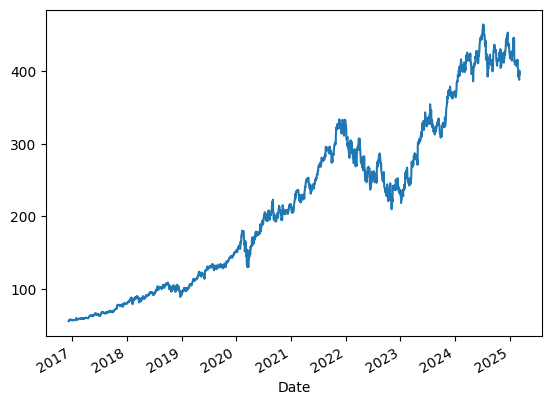

In [28]:
df.Close.plot();